# Healy chapter 6 figures (2022-09-02)

_by A. Maurits van der Veen_  

_Modification history:_  
_2022-08-20 - Initial version_  

This notebook provides python code to parallel the R code in Healy's Data Visualization book. 

It uses the `plotnine` module in python, which replicates most of ggplot.

This chapter, which uses a number of stats-related R packages, occasionally executes code in R
(using `rpy2`), but the key plotting takes place back in python.


## 0. General preparation

The code relies on several python modules, which may need to be installed first. To do so, uncomment the next X code snippets.

- `plotnine` is the main module replicating 
- `mizani` provides axis label formatting
- `pyreadr` reads R-format datasets
- `adjustText` is used to move text around to avoid overlapping (alternative to ggrepel)
- `rpy2` makes it possible to execute R code within a python notebook


In [ ]:
# !pip install plotnine


In [ ]:
# !pip install mizani


In [ ]:
# !pip install pyreadr


In [ ]:
# !pip install adjustText


In [ ]:
# !pip install rpy2


In [105]:
import math
import numpy as np

import pandas as pd
# import geopandas as gpd  # Not necessary until chapter 7

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

from plotnine import *  # alternative: import plotnine as p9 and always use prefix
from mizani.formatters import currency_format, percent_format, custom_format

import adjustText

import pyreadr

import rpy2

## Chapter 6 - Work with models

The headings below correspond to chapter sections in the book (and share the same titles). If a heading number is skipped (as is the case for 6.3 here), that is because there are no figures in those sections. Where the title is purely R-specific (as in section 6.5 here), I have added an adjustment in italics.

In [3]:
localfolder = '/Users/yourname/Downloads/'  # Change to local path


In [4]:
# Retrieve and load gapminder data

remotefolder = 'https://github.com/jennybc/gapminder/blob/main/data/'

datasetname = 'gapminder'
targetfile = datasetname + '.rdata'
pyreadr.download_file(remotefolder + targetfile + '?raw=true', 
                      localfolder + targetfile)
newdata = pyreadr.read_r(localfolder + targetfile)
gapminder = newdata[datasetname]


In [196]:
# Retrieve & load data from the website associated with Healy's book

remotefolder = 'https://github.com/kjhealy/socviz/blob/master/data/'

datasetname = 'gss_sm'
targetfile = datasetname + '.rda'
pyreadr.download_file(remotefolder + targetfile + '?raw=true', localfolder + targetfile)
newdata = pyreadr.read_r(localfolder + targetfile)
gss_sm = newdata[datasetname]

datasetname = 'gss_lon'
targetfile = datasetname + '.rda'
pyreadr.download_file(remotefolder + targetfile + '?raw=true', localfolder + targetfile)
newdata = pyreadr.read_r(localfolder + targetfile)
gss_lon = newdata[datasetname]

datasetname = 'organdata'
targetfile = datasetname + '.rda'
pyreadr.download_file(remotefolder + targetfile + '?raw=true', localfolder + targetfile)
newdata = pyreadr.read_r(localfolder + targetfile)
organdata = newdata[datasetname]


/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:153: PlotnineWarning: Confidence intervals are not yet implemented for RLM smoothing.


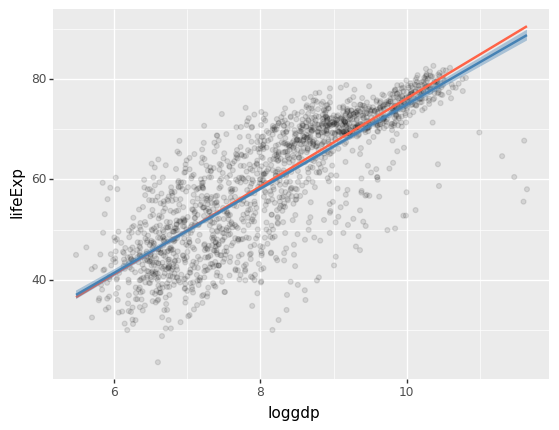

<ggplot: (310877928)>

In [5]:
# Figure 6.1a 
# Note: Figure 6.1 has 3 parts; I have sub-labeled them with letters a-c

gapminder['loggdp'] = gapminder.apply(lambda row: math.log(row['gdpPercap']), axis = 1)

p = ggplot(data = gapminder,
           mapping = aes(x = 'loggdp', y = 'lifeExp'))

(p + geom_point(alpha = 0.1) +
     geom_smooth(color = 'tomato', fill = 'tomato', method = 'rlm') +
     geom_smooth(color = 'steelblue', fill = 'steelblue', method = 'lm')
)


In [7]:
# As an alternative to the splines::bs() option in ggplot, 
# define our own straightforward polynomial function

def poly(x, degree=1):
    """
    Fit Polynomial (by has2k1, the author of plotnine)

    These are non orthogonal factors, but it may not matter if
    we only need this for smoothing and not extrapolated
    predictions.
    
    From: https://stackoverflow.com/questions/63344621/fit-non-linear-curve-using-plotnine
    """
    d = {}
    for i in range(degree+1):
        if i == 1:
            d['x'] = x
        else:
            d[f'x**{i}'] = np.power(x, i)
    return pd.DataFrame(d)


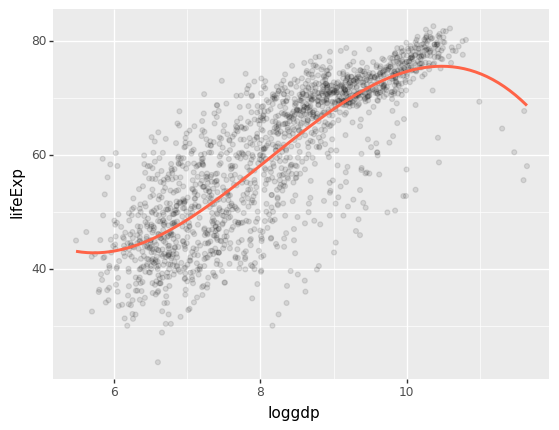

<ggplot: (310999824)>

In [8]:
# Figure 6.1b

(p + geom_point(alpha = 0.1) +
     geom_smooth(color = 'tomato', method = 'lm', size = 1.2,
                 formula = 'y ~ poly(x, degree = 3)', se = False)
)


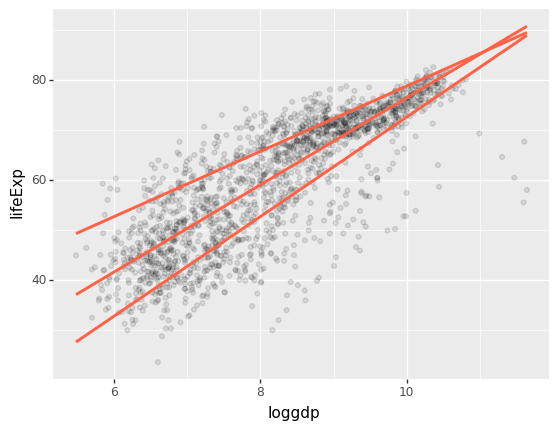

<ggplot: (311151876)>

In [11]:
# Figure 6.1c 
# Note: the curvy shapes in Healy may be due to the 'rqss' method 
# (and the value of the lambda parameter that goes with it)
# I do not believe a comparable method is currently implemented in plotnine

(p + geom_point(alpha = 0.1) +
     geom_quantile(color = 'tomato', size = 1.2,
                   quantiles = (0.2, 0.5, 0.85))
)


### 6.1 Show several fits at once, with a legend

In [14]:
# Get suitable colors for each model (hex codes copied from bottom of p. 135)
model_colors = ('#E41A1C', '#377EB8', '#4DAF4A')

# Generate variables for the different colors
# Assign them the legend name we want
OLS = 'ols'
CS = 'cubic spline'
LOESS = 'loess'

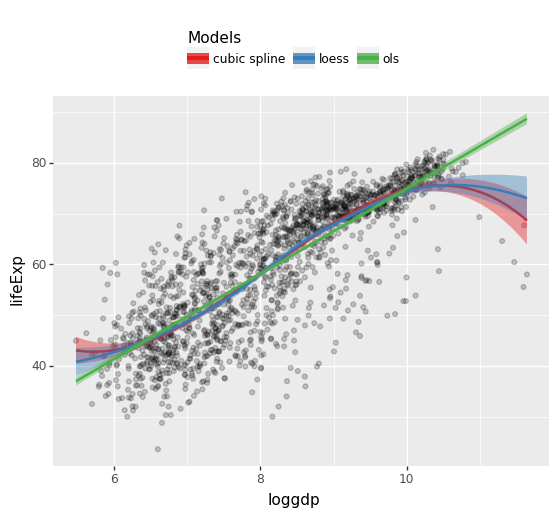

<ggplot: (321734141)>

In [16]:
# Figure 6.2
# Note that the ordering of the geom_smooth specs in this code is the reverse
# of that in Healy, but the ordering in the chart is the same

(p + geom_point(alpha = 0.2) +
     geom_smooth(method = 'lm', formula = 'y ~ poly(x, degree = 3)',
                                mapping = aes(color = 'CS', fill = 'CS')) + 
     geom_smooth(method = 'loess', mapping = aes(color = 'LOESS', fill = 'LOESS')) +
     geom_smooth(method = 'lm', mapping = aes(color = "OLS", fill = "OLS")) +
     scale_color_manual(name = 'Models', values = model_colors) +
     scale_fill_manual(name = 'Models', values = model_colors) +
     theme(legend_position = 'top')
)

### 6.2 Look inside model objects

In [17]:
# Prepare to convert single 'continent' variable to a set of dummies

continents = ('Africa', 'Americas', 'Asia', 'Europe', 'Oceania')
continentvars = ['continent_' + cont for cont in continents]

In [20]:
# Generate dummy variables

dummies = pd.get_dummies(gapminder, columns=['continent'])
dummies

,country,year,lifeExp,pop,gdpPercap,loggdp,continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania
0,Afghanistan,1952,28.801,8425333,779.445314,6.658583,0,0,1,0,0
1,Afghanistan,1957,30.332,9240934,820.853030,6.710344,0,0,1,0,0
2,Afghanistan,1962,31.997,10267083,853.100710,6.748878,0,0,1,0,0
3,Afghanistan,1967,34.020,11537966,836.197138,6.728864,0,0,1,0,0
4,Afghanistan,1972,36.088,13079460,739.981106,6.606625,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1699,Zimbabwe,1987,62.351,9216418,706.157306,6.559838,1,0,0,0,0
1700,Zimbabwe,1992,60.377,10704340,693.420786,6.541637,1,0,0,0,0
1701,Zimbabwe,1997,46.809,11404948,792.449960,6.675129,1,0,0,0,0
1702,Zimbabwe,2002,39.989,11926563,672.038623,6.510316,1,0,0,0,0


In [21]:
# Run model and display summary of results
# (compare output on p. 139 of book)

model = smf.ols(formula = 'lifeExp ~ gdpPercap + pop + ' + ' + '.join(continentvars[1:]), data=dummies)

out = model.fit()
out.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeExp   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     393.9
Date:                Fri, 02 Sep 2022   Prob (F-statistic):          3.94e-317
Time:                        14:52:34   Log-Likelihood:                -6033.8
No. Observations:                1704   AIC:                         1.208e+04
Df Residuals:                    1697   BIC:                         1.212e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             47.8141      0.340    140.819      0.000      47.148      48.480
gdpPercap              0.0004   2.35e-05     19.158      0.000       0.000       0.000
pop                  6.57e-09   1.98e-09      3.326      0.001     2.7e-09    1.04e-08
continent_Americas    13.4759      0.600     22.458      0.000      12.299      14.653
continent_Asia         8.1926      0.571     14.342      0.000       7.072       9.313
continent_Europe      17.4727      0.625     27.973      0.000      16.248      18.698
continent_Oceania     18.0833      1.782     10.146      0.000      14.588      21.579
==============================================================================
Omnibus:                      146.151   Durbin-Watson:                   0.480
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              332.829
Skew:                          -0.518   Prob(JB):                     5.33e-73
Kurtosis:                       4.901   Cond. No.                     9.76e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.76e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
out.params  # A way to extract just the coefficient estimates

Intercept             4.781408e+01
gdpPercap             4.495058e-04
pop                   6.569823e-09
continent_Americas    1.347594e+01
continent_Asia        8.192632e+00
continent_Europe      1.747269e+01
continent_Oceania     1.808330e+01
dtype: float64

### 6.4 Generate predictions to graph

In [24]:
# Generate data for out-of-sample prediction (fitted values)

# Get minimum and maximum values, to serve as endpoints for our simulated value range
nrvals = 100
min_gdp = gapminder['gdpPercap'].min()
max_gdp = gapminder['gdpPercap'].max()
gdp_vals = np.linspace(min_gdp, max_gdp, nrvals)

# Get median of population
med_pop = gapminder['pop'].median()

# Holding population constant at its median, cycle across gdp values and continents
grid_data = [[gdpcap, med_pop, cont] for gdpcap in gdp_vals for cont in continents]
pred_df = pd.DataFrame(grid_data, columns=['gdpPercap', 'pop', 'continent'])

# Add in continent variables -- not the most efficient way to do this, but easy to follow
for cont in continents:
    pred_df['continent_' + cont] = np.where(pred_df['continent'] == cont, 1, 0)
    
# Add constant (necessary for the prediction function)
pred_df['constant'] = 1


In [25]:
# Predict using the output of our OLS regression
# This code predicts only the mean

ynewpred = out.predict(pred_df)  # predict out of sample
ynewpred

0       47.968628
1       61.444571
2       56.161260
3       65.441320
4       66.051932
          ...    
495     98.889524
496    112.365467
497    107.082156
498    116.362217
499    116.972828
Length: 500, dtype: float64

In [26]:
# This code also predicts confidence intervals, which we need

predictions = out.get_prediction(pred_df)
predictions.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,47.968628,0.338092,47.305507,48.631748,31.547749,64.389507
1,61.444571,0.511111,60.442097,62.447045,45.006490,77.882652
2,56.161260,0.480473,55.218878,57.103641,39.726734,72.595785
3,65.441320,0.554044,64.354639,66.528002,48.997890,81.884751
4,66.051932,1.761240,62.597500,69.506364,49.284743,82.819121
...,...,...,...,...,...,...
495,98.889524,2.633225,93.724815,104.054233,81.688368,116.090680
496,112.365467,2.540872,107.381895,117.349040,95.217828,129.513107
497,107.082156,2.510012,102.159111,112.005200,89.952010,124.212302
498,116.362217,2.364585,111.724408,121.000025,99.311856,133.412578


In [27]:
# Merge the independent variable values in pred_df with the prediction data

pred_df = pred_df.merge(predictions.summary_frame(alpha = 0.05),
                        left_index=True, right_index=True)
pred_df.head()

,gdpPercap,pop,continent,continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,constant,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,241.165876,7023595.5,Africa,1,0,0,0,0,1,47.968628,0.338092,47.305507,48.631748,31.547749,64.389507
1,241.165876,7023595.5,Americas,0,1,0,0,0,1,61.444571,0.511111,60.442097,62.447045,45.006490,77.882652
2,241.165876,7023595.5,Asia,0,0,1,0,0,1,56.161260,0.480473,55.218878,57.103641,39.726734,72.595785
3,241.165876,7023595.5,Europe,0,0,0,1,0,1,65.441320,0.554044,64.354639,66.528002,48.997890,81.884751
4,241.165876,7023595.5,Oceania,0,0,0,0,1,1,66.051932,1.761240,62.597500,69.506364,49.284743,82.819121


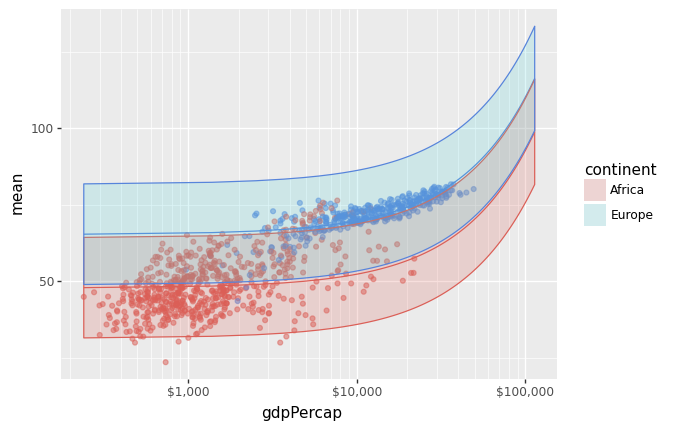

<ggplot: (311156679)>

In [28]:
# Figure 6.4

p = ggplot(data = pred_df[pred_df['continent'].isin(('Europe', 'Africa'))],
           mapping = aes(x = 'gdpPercap',
                         y = 'mean', ymin = 'obs_ci_lower', ymax = 'obs_ci_upper',
                         color = 'continent', fill = 'continent', 
                         group = 'continent'))

(p + geom_point(data = gapminder[gapminder['continent'].isin(('Europe', 'Africa'))],
                mapping = aes(x = 'gdpPercap', y = 'lifeExp', color = 'continent'),
                alpha = 0.5,
                inherit_aes = False) +
     geom_line() +
     geom_ribbon(alpha = 0.2) +
     guides(color = False) +
     scale_x_log10(labels = currency_format(digits=0, big_mark=','))
)

### 6.5 Tidy model objects with `broom` _(no broom in python; just access model summary directly)_

In [29]:
# Analog to the table on p. 147

results_as_html = out.summary().tables[1].as_html()
out_comp = pd.read_html(results_as_html, header=0, index_col=0)[0].round(decimals=2)
out_comp['variable'] = out_comp.index
out_comp

,coef,std err,t,P>|t|,[0.025,0.975],variable
Intercept,47.81,0.34,140.82,0.0,47.15,48.48,Intercept
gdpPercap,0.00,0.00,19.16,0.0,0.00,0.00,gdpPercap
pop,0.00,0.00,3.33,0.0,0.00,0.00,pop
continent_Americas,13.48,0.60,22.46,0.0,12.30,14.65,continent_Americas
continent_Asia,8.19,0.57,14.34,0.0,7.07,9.31,continent_Asia
continent_Europe,17.47,0.62,27.97,0.0,16.25,18.70,continent_Europe
continent_Oceania,18.08,1.78,10.15,0.0,14.59,21.58,continent_Oceania


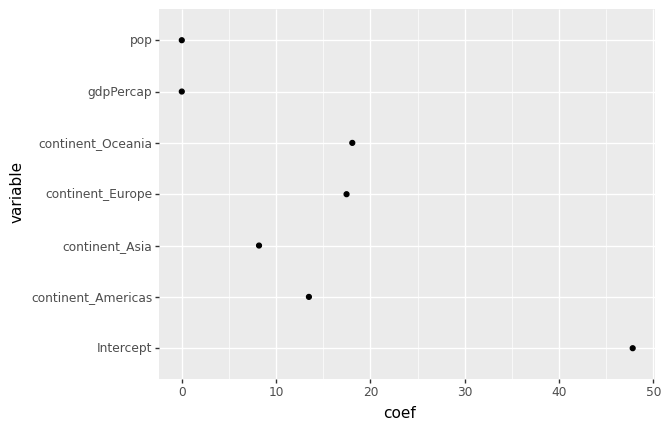

<ggplot: (320241026)>

In [201]:
# Figure 6.5

p = ggplot(data = out_comp,
           mapping = aes(x = 'variable',
                         y = 'coef'))

p + geom_point() + coord_flip()

In [30]:
# Removing the intercept, which is an outlier

out_conf = out_comp[out_comp['variable'] != 'Intercept']

In [31]:
out_conf

,coef,std err,t,P>|t|,[0.025,0.975],variable
gdpPercap,0.00,0.00,19.16,0.0,0.00,0.00,gdpPercap
pop,0.00,0.00,3.33,0.0,0.00,0.00,pop
continent_Americas,13.48,0.60,22.46,0.0,12.30,14.65,continent_Americas
continent_Asia,8.19,0.57,14.34,0.0,7.07,9.31,continent_Asia
continent_Europe,17.47,0.62,27.97,0.0,16.25,18.70,continent_Europe
continent_Oceania,18.08,1.78,10.15,0.0,14.59,21.58,continent_Oceania


In [32]:
# Removing the prefix from the continent variables

prefix2strip = 'continent_'
p2slen = len(prefix2strip)

out_conf['variable'].replace(to_replace = {varval : varval[p2slen:] \
                                           for varval in out_conf.index \
                                           if varval[:p2slen] == prefix2strip},
                             inplace = True)
out_conf

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,coef,std err,t,P>|t|,[0.025,0.975],variable
gdpPercap,0.00,0.00,19.16,0.0,0.00,0.00,gdpPercap
pop,0.00,0.00,3.33,0.0,0.00,0.00,pop
continent_Americas,13.48,0.60,22.46,0.0,12.30,14.65,Americas
continent_Asia,8.19,0.57,14.34,0.0,7.07,9.31,Asia
continent_Europe,17.47,0.62,27.97,0.0,16.25,18.70,Europe
continent_Oceania,18.08,1.78,10.15,0.0,14.59,21.58,Oceania


In [33]:
# Note: we can sort the dataframe in the desired order, 
# but the plotting happens in alphabetic order, so this does not help

out_conf = out_conf.sort_values(by = ['coef',], ascending = True)
out_conf

,coef,std err,t,P>|t|,[0.025,0.975],variable
gdpPercap,0.00,0.00,19.16,0.0,0.00,0.00,gdpPercap
pop,0.00,0.00,3.33,0.0,0.00,0.00,pop
continent_Asia,8.19,0.57,14.34,0.0,7.07,9.31,Asia
continent_Americas,13.48,0.60,22.46,0.0,12.30,14.65,Americas
continent_Europe,17.47,0.62,27.97,0.0,16.25,18.70,Europe
continent_Oceania,18.08,1.78,10.15,0.0,14.59,21.58,Oceania


In [34]:
# Instead, add categorical variable based on the sorted values
out_conf = out_conf.sort_values(by = ['coef',], ascending = True)

varlist = list(out_conf['variable'])
var_cat = pd.Categorical(out_conf['variable'], categories=varlist)

# assign to a new column in the DataFrame
out_conf = out_conf.assign(var_cat = var_cat)


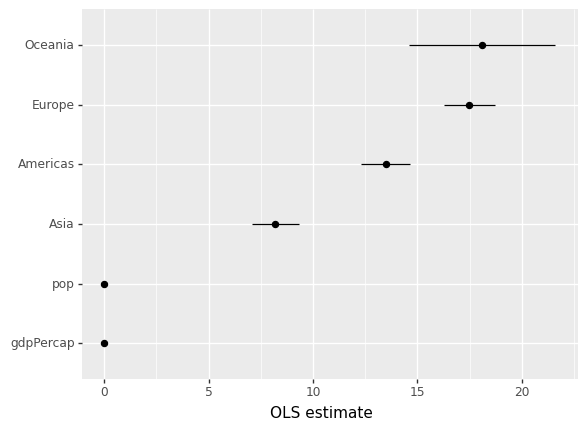

<ggplot: (322017268)>

In [35]:
# Figure 6.6

p = ggplot(data = out_conf,
           mapping = aes(x = 'var_cat',
                         y = 'coef', ymin = '[0.025', ymax = '0.975]'))

(p + geom_pointrange() +
     coord_flip() +
     labs(x = '', y = 'OLS estimate')
)

In [36]:
# Extract fitted & residual values

out_aug = pd.DataFrame(zip(out.fittedvalues, out.resid), columns=('fitted', 'residual'))
out_aug.head()

,fitted,residual
0,56.412428,-27.611428
1,56.436400,-26.104400
2,56.457637,-24.460637
3,56.458388,-22.438388
4,56.425266,-20.337266


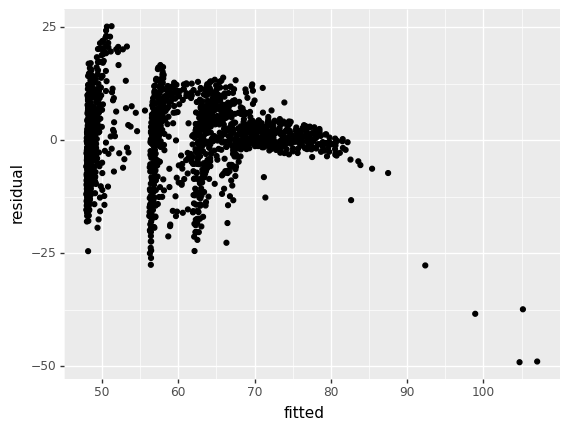

<ggplot: (322015335)>

In [37]:
# Figure 6.7

p = ggplot(data = out_aug,
           mapping = aes(x = 'fitted', y = 'residual'))
p + geom_point()


#### Get model-level statistics with `glance`

The figure in this section (fig. 6.8) relies on the `survival` package in R. There is an analog to this package in python (`scikit-survival`), but it is not a perfect match. Rather than try to recreate the graph using `scikit-survival`, this is an opportunity to demonstrate the strength of the `rpy2` module, which allows for the execution of R code within a python notebook.

_Caveat: To run `rpy2` it is necessary to have R install on your system, along with any packages to be used._

In [40]:
# Dataset 'lung' from the R survival package - downloadable from https://r-data.pmagunia.com/

lung = pd.read_csv(localfolder + 'dataset-68740.csv')
lung.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


In [42]:
# Prepare to import the needed R libraries into the local environment

from rpy2.robjects.packages import importr

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [43]:
# Import the relevant libraries 
# (note that these must be installed in your system's R environment)

tidyverse = importr('tidyverse')
ggplot = importr('ggplot2')
survival = importr('survival')
broom = importr('broom')

In [54]:
%%R

# Unload the packages again, to avoid cluttering up the namespace

detach("package:tidyverse")
detach("package:ggplot2")
detach("package:survival")
detach("package:broom")

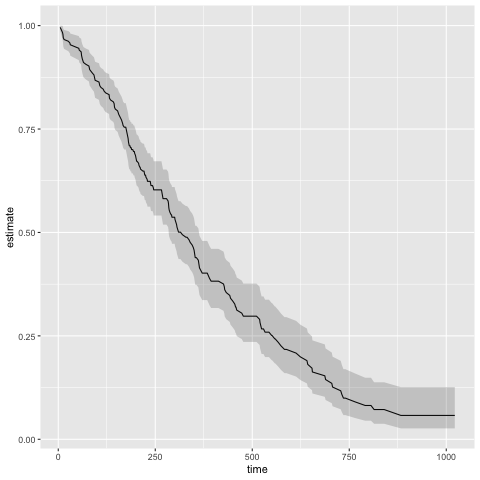

In [47]:
%%R

# Figure 6.8 -- using rpy2
# Note the %%R flag at the top, indicating this code snippet is in R

library(survival)
library(tidyverse)
library(ggplot2)
library(broom)

out_cph <- coxph(Surv(time, status) ~ age + sex, data = lung)
out_surv <- survfit(out_cph)

out_tidy <- tidy(out_surv)

p <- ggplot(data = out_tidy, mapping = aes(time, estimate))
p + geom_line() +
    geom_ribbon(mapping = aes(ymin = conf.low, ymax = conf.high), alpha = .2)

In [63]:
# Note that we have not made ggplot an R function
# To reset it to the plotnine version, we must run the following line

from plotnine import *


### 6.6 Grouped analysis and list columns

In [48]:
# Subset the gapminder dataset (could also be done on the fly)

eu77 = gapminder[(gapminder['continent'] == 'Europe') & (gapminder['year'] == 1977)]
len(eu77)

30

In [49]:
# Run analysis; compare results to those on p. 152

model = smf.ols('lifeExp ~ loggdp', data = eu77)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeExp   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     35.24
Date:                Fri, 02 Sep 2022   Prob (F-statistic):           2.17e-06
Time:                        15:18:42   Log-Likelihood:                -63.984
No. Observations:                  30   AIC:                             132.0
Df Residuals:                      28   BIC:                             134.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.4891      7.161      4.118      0.000      14.820      44.158
loggdp         4.4877      0.756      5.936      0.000       2.939       6.036
==============================================================================
Omnibus:                       17.445   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.773
Skew:                          -1.292   Prob(JB):                     1.54e-06
Kurtosis:                       6.839   Cond. No.                         178.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# Generalize the above -- run across continents and years

outdata = []

for groupid, groupdata in gapminder.groupby(['continent', 'year']):
    if groupid[0] == 'Oceania':  # Too few countries in Oceania -> skip
        continue
    fit = smf.ols('lifeExp ~ loggdp', data = groupdata).fit()
    results_as_html = fit.summary().tables[1].as_html()
    out_comp = pd.read_html(results_as_html, header=0, index_col=0)[0]
    outdata.append(list(groupid) + out_comp.loc[['loggdp',]].values.flatten().tolist())
    

# Convert results to a dataframe
# Note that we obtain the confint_low and _hi variables directly from the results,
# rather than calculating them on the fly as in Healy's code (see p. 156)

out_tidy = pd.DataFrame(outdata, columns = ('continent', 'year', 
                                            'coef', 'stderr', 't', 'p_value', 'confint_low', 'confint_hi'))
out_tidy.head()

,continent,year,coef,stderr,t,p_value,confint_low,confint_hi
0,Africa,1952,2.3375,0.971,2.406,0.020,0.386,4.289
1,Africa,1957,2.6880,1.056,2.547,0.014,0.568,4.808
2,Africa,1962,2.7563,1.058,2.604,0.012,0.630,4.882
3,Africa,1967,3.0685,0.988,3.105,0.003,1.084,5.053
4,Africa,1972,3.8035,0.962,3.952,0.000,1.870,5.737


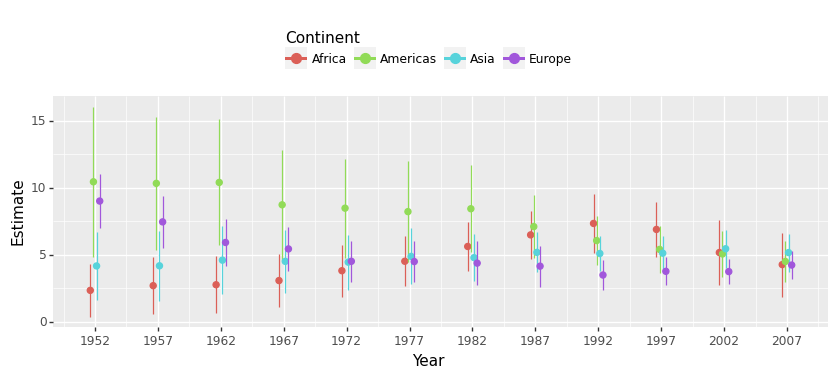

<ggplot: (327812485)>

In [62]:
# Figure 6.9

p = ggplot(data = out_tidy,
           mapping = aes(x = 'year', 
                         y = 'coef', ymin = 'confint_low', ymax = 'confint_hi',
                         group = 'continent', color = 'continent'))

(p + geom_pointrange(position = position_dodge(width = 1)) +
     scale_x_continuous(breaks = gapminder['year'].unique()) +
     theme(legend_position = 'top') + 
     labs(x = 'Year', y = 'Estimate', color = 'Continent') +
     theme(figure_size = (10, 3))
)

### 6.7 Plot marginal effects _(no margins package; work-around instead)_

In [67]:
# Check to see what values the 'polviews' variable has
gss_sm['polviews']

0                    Moderate
1                     Liberal
2                Conservative
3                    Moderate
4            Slightly Liberal
                ...          
2862        Extremely Liberal
2863             Conservative
2864                 Moderate
2865    Slightly Conservative
2866    Slightly Conservative
Name: polviews, Length: 2867, dtype: category
Categories (7, object): ['Conservative', 'Extremely Conservative', 'Extremely Liberal', 'Liberal', 'Moderate', 'Slightly Conservative', 'Slightly Liberal']

In [68]:
# Run a generalized linear model

model_bo = smf.glm("obama ~ C(polviews, Treatment(reference='Moderate')) + sex*race", family = sm.families.Binomial(), 
                   data = gss_sm)
out_bo = model_bo.fit()


In [69]:
# Inspect results
# Note that the reference variable is different here, so the intercept also has a different value

out_bo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  obama   No. Observations:                 1698
Model:                            GLM   Df Residuals:                     1686
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -672.94
Date:                Fri, 02 Sep 2022   Deviance:                       1345.9
Time:                        15:35:37   Pearson chi2:                 1.64e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4121
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  4.2034      0.448      9.383      0.000       3.325       5.081
C(polviews, Treatment(reference='Moderate'))[T.Conservative]              -2.3475      0.200    -11.715      0.000      -2.740      -1.955
C(polviews, Treatment(reference='Moderate'))[T.Extremely Conservative]    -2.7274      0.387     -7.044      0.000      -3.486      -1.968
C(polviews, Treatment(reference='Moderate'))[T.Extremely Liberal]          2.3730      0.525      4.520      0.000       1.344       3.402
C(polviews, Treatment(reference='Moderate'))[T.Liberal]                    2.6000      0.357      7.290      0.000       1.901       3.299
C(polviews, Treatment(reference='Moderate'))[T.Slightly Conservative]     -1.3553      0.181     -7.476      0.000      -1.711      -1.000
C(polviews, Treatment(reference='Moderate'))[T.Slightly Liberal]           1.2932      0.248      5.205      0.000       0.806       1.780
sex[T.Male]                                                               -0.0574      0.644     -0.089      0.929      -1.320       1.205
race[T.Other]                                                             -2.0793      0.574     -3.626      0.000      -3.203      -0.955
race[T.White]                                                             -3.6520      0.447     -8.165      0.000      -4.529      -2.775
sex[T.Male]:race[T.Other]                                                 -1.7723      0.861     -2.058      0.040      -3.460      -0.084
sex[T.Male]:race[T.White]                                                 -0.1975      0.660     -0.299      0.765      -1.491       1.096
==========================================================================================================================================
"""

In [70]:
# statsmodels' GLM has no marginal effects function
# Could program our own here or run through r2py to get results.

# For the moment, just hard-code it, by copying from the online data at socviz.co

# Copy & paste data here
data_as_string = \
'## 1 Conservative           -0.412  -0.467   -0.356 \n' + \
'## 2 Extremely Conservative -0.454  -0.536   -0.371 \n' + \
'## 3 Extremely Liberal       0.268   0.210    0.326 \n' + \
'## 4 Liberal                 0.277   0.232    0.322 \n' + \
'## 5 Slightly Conservative  -0.266  -0.330   -0.201 \n' + \
'## 6 Slightly Liberal        0.193   0.134    0.253 \n' + \
'## 7 Race: Black             0.403   0.369    0.437 \n' + \
'## 8 Race: Other             0.125   0.0490   0.200 \n' + \
'## 9 Female                  0.0443  0.00967  0.0789'

# Parse string-format data into values
datalines = [x[5:] for x in data_as_string.split('\n')]
datalists = [x.split() for x in datalines]
datalists = [[' '.join(x[:2]),] + x[2:] if x[1][0] in 'CLBO' else x for x in datalists]
datalists = [[x[0],] + [float(y) for y in x[1:]] for x in datalists]
bo_gg = pd.DataFrame(datalists, columns=('factor', 'AME', 'lower', 'upper'))
bo_gg

,factor,AME,lower,upper
0,Conservative,-0.4120,-0.46700,-0.3560
1,Extremely Conservative,-0.4540,-0.53600,-0.3710
2,Extremely Liberal,0.2680,0.21000,0.3260
3,Liberal,0.2770,0.23200,0.3220
4,Slightly Conservative,-0.2660,-0.33000,-0.2010
5,Slightly Liberal,0.1930,0.13400,0.2530
6,Race: Black,0.4030,0.36900,0.4370
7,Race: Other,0.1250,0.04900,0.2000
8,Female,0.0443,0.00967,0.0789


In [71]:
# Add categorical variable based on the sorted values
bo_gg = bo_gg.sort_values(by = ['AME',], ascending = True)

varlist = list(bo_gg['factor'])
var_cat = pd.Categorical(bo_gg['factor'], categories=varlist)

# assign to a new column in the DataFrame
bo_gg = bo_gg.assign(var_cat = var_cat)


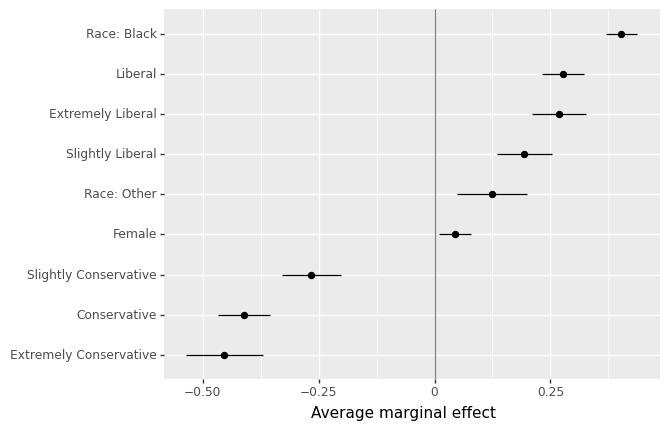

<ggplot: (325191617)>

In [72]:
# Figure 6.10

p = ggplot(data = bo_gg,
           mapping = aes(x = 'var_cat',
                         y = 'AME', ymin = 'lower', ymax = 'upper'))

(p + geom_hline(yintercept = 0, color = 'gray') +
     geom_pointrange() +
     coord_flip() + 
     labs(x = '', y = 'Average marginal effect')
)

In [74]:
# Figure 6.11 uses a specific feature of the margins package -- run through r2py

margins = importr('margins')  # Import margins package


In [84]:
%%R -i gss_sm -o pv_cp

# Use our already loaded version of gss_sm,
# and export the pv_cp dataframe back to python for our use

library(margins)

gss_sm$polviews_m <- relevel(gss_sm$polview, ref = "Moderate")
out_bo <- glm(obama ~ polviews_m + sex*race,
              family = "binomial", data = gss_sm)
summary(out_bo)

pv_cp <- cplot(out_bo, x = "sex", draw = FALSE)

In [90]:
pv_cp  # Inspect, to check that it came through correctly

,xvals,yvals,upper,lower
1,Female,0.634451,0.688784,0.580117
2,Male,0.573585,0.637865,0.509304


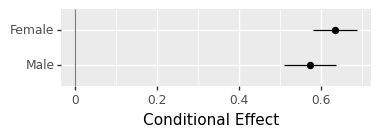

<ggplot: (322111964)>

In [95]:
# Figure 6.11 (here we're back in python)

p = ggplot(data = pv_cp, 
           mapping = aes(x = 'reorder(xvals, yvals)',
                         y = 'yvals', ymin = 'lower', ymax = 'upper'))

p + geom_hline(yintercept = 0, color = "gray") +\
    geom_pointrange() +\
    coord_flip() +\
    labs(x = '', 
         y = "Conditional Effect") +\
     theme(figure_size = (4, 1))

### 6.8 Plots from complex surveys

Figures 6.12 and 6.13 use survey analysis. There are good modules for this in python (e.g. `samplics`), but since our focus here is on the plotting, we'll do the survey analysis using `rpy2`, and return to do the plotting in python.

In [97]:
survey = importr('survey')  # Import survey packages into our R environment
srvyr = importr('srvyr')


In [100]:
%%R -i gss_lon -o out_grp

# We don't stop along the way to inspect intermediate tibbles,
# but could do that easily enough

gss_wt <- subset(gss_lon, year > 1974) %>%
    mutate(stratvar = interaction(year, vstrat)) %>%
    as_survey_design(ids = vpsu,
                     strata = stratvar,
                     weights = wtssall,
                     nest = TRUE)

out_grp <- gss_wt %>%
    filter(year %in% seq(1976, 2016, by = 4)) %>%
    group_by(year, race, degree) %>%
    summarize(prop = survey_mean(na.rm = TRUE))

# Note that out_mrg is not used in the plotting commands
# The first version of out_mrg in the book does not separate race & degree

# out_mrg <- gss_wt %>%
#     filter(year %in% seq(1976, 2016, by = 4)) %>%
#     mutate(racedeg = interaction(race, degree)) %>%
#     group_by(year, racedeg) %>%
#     summarize(prop = survey_mean(na.rm = TRUE))

out_mrg <- gss_wt %>%
    filter(year %in% seq(1976, 2016, by = 4)) %>%
    mutate(racedeg = interaction(race, degree)) %>%
    group_by(year, racedeg) %>%
    summarize(prop = survey_mean(na.rm = TRUE)) %>%
    separate(racedeg, sep = "\\.", into = c("race", "degree"))

out_mrg

# A tibble: 155 × 5
# Groups:   year [10]
    year race  degree             prop  prop_se
   <dbl> <chr> <chr>             <dbl>    <dbl>
 1  1976 Black Bachelor       0.00486  0.00213 
 2  1976 Other Bachelor       0.00194  0.00144 
 3  1976 White Bachelor       0.0916   0.00883 
 4  1976 Other Graduate       0.000648 0.000650
 5  1976 White Graduate       0.0356   0.00597 
 6  1976 Black High School    0.0282   0.00593 
 7  1976 Other High School    0.00324  0.00166 
 8  1976 White High School    0.469    0.0159  
 9  1976 Black Junior College 0.00356  0.00162 
10  1976 White Junior College 0.0117   0.00268 
# … with 145 more rows
# ℹ Use `print(n = ...)` to see more rows


In [102]:
# Check to see what out_grp looks like
out_grp.head()

,year,race,degree,prop,prop_se
1,1976.0,1,1,0.057693,0.023751
2,1976.0,1,3,0.334615,0.047554
3,1976.0,1,4,0.042309,0.019172
4,1976.0,1,5,0.557691,0.060317
5,1976.0,1,-2147483648,0.007693,0.007533


In [112]:
# Generate low & high CI values

out_grp['prop_low'] = out_grp['prop'] - 2 * out_grp['prop_se']
out_grp['prop_high'] = out_grp['prop'] + 2 * out_grp['prop_se']


In [128]:
# Save backup before we start messing with values
out_grp_bkup = out_grp.copy()

In [165]:
out_grp.head()  # year, race, and degree are now all floats (which is wrong)


,year,race,degree,prop,prop_se,prop_low,prop_high
1,1976.0,1,1,0.057693,0.023751,0.010192,0.105195
2,1976.0,1,3,0.334615,0.047554,0.239507,0.429722
3,1976.0,1,4,0.042309,0.019172,0.003964,0.080653
4,1976.0,1,5,0.557691,0.060317,0.437057,0.678325
5,1976.0,1,-2147483648,0.007693,0.007533,-0.007373,0.022758


In [166]:
# Convert to integers

out_grp['year'] = out_grp['year'].astype('int')
out_grp['race'] = out_grp['race'].astype('int')
out_grp['degree'] = out_grp['degree'].astype('int')


In [167]:
# Note that the integer values assigned are in no obvious order.
# To make sure of the correct mapping, it is best to display the
# dataframe in R, and note the actual values associated with different
# race-degree combinations

# Map race from int to string

out_grp['race'].replace({1: 'Black',
                         2: 'Other',
                         3: 'White'}, inplace=True)

# Map degree from int to string

minval = out_grp['degree'].min()
out_grp['degree'].replace({minval: np.NaN,
                           1: 'Bachelor',
                           2: 'Graduate',
                           3: 'High school', 
                           4: 'Junior college',
                           5: 'Lt high school'
                          }, inplace=True)


In [168]:
# Add order to degree data

educ_attain = ('Lt high school', 'High school', 'Junior college',
               'Bachelor', 'Graduate')
out_grp = out_grp[(out_grp['degree'].isin(educ_attain))]

degree_order = pd.Categorical(out_grp['degree'], categories=educ_attain)

# assign to a new column in the DataFrame
out_grp = out_grp.assign(degree_order = degree_order)


In [172]:
# Add order to race data

race_vals = ('White', 'Black')

out_grp = out_grp[(out_grp['race'].isin(race_vals))]

race_order = pd.Categorical(out_grp['race'], categories=race_vals)

# assign to a new column in the DataFrame
out_grp = out_grp.assign(race_order = race_order)


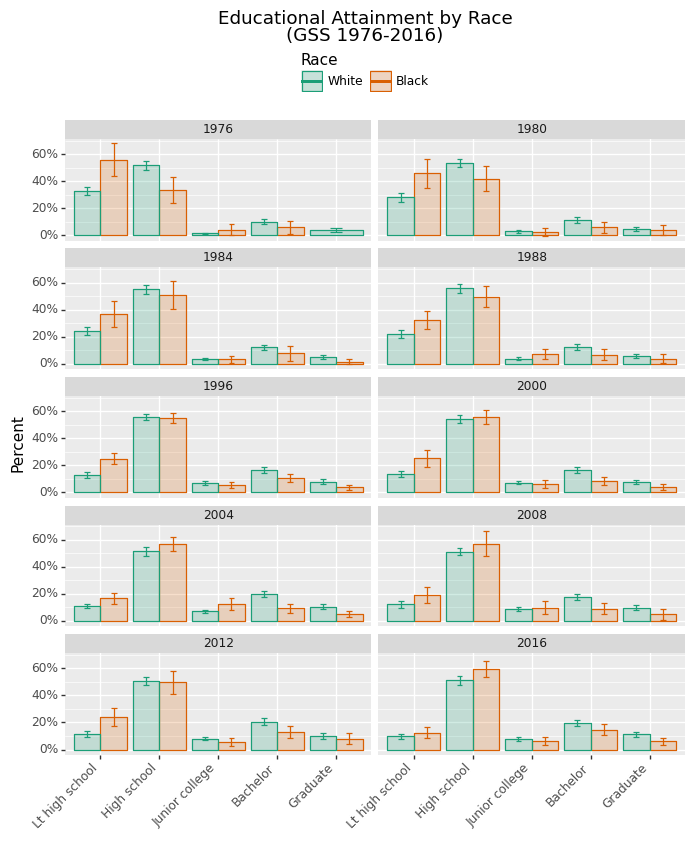

<ggplot: (328634634)>

In [181]:
# Figure 6.12

# Use the ordered variables instead of the originals
# To make this nicer, we could rename them to drop the '_order' part from the axis labels

# We need to add a bunch of blank lines to the end of the title 
# to make sure it does not overlap with the legend

# Instead of wrapping x-axis value with scales::wrap_format(), use the element_text
# rotation option in the theme. To mimic wrap_format(), export to matplotlib
# and simply write a wrapping function for x-axis labels

p = ggplot(data = out_grp,
           mapping = aes(x = 'degree_order', 
                         y = 'prop', ymin = 'prop_low', ymax = 'prop_high',
                         fill = 'race_order',
                         color = 'race_order',
                         group = 'race_order'))

dodge = position_dodge(width=0.9)

(p + geom_col(position = dodge, alpha = 0.2) +
     geom_errorbar(position = dodge, width = 0.2) +
     scale_y_continuous(labels = percent_format()) +
     scale_color_brewer(type = "qual", palette = "Dark2") +
     scale_fill_brewer(type = "qual", palette = "Dark2") +
     labs(title = "Educational Attainment by Race\n(GSS 1976-2016)\n\n\n\n",
          fill = "Race",
          color = "Race",
          x = '', y = "Percent") +
     facet_wrap('year', ncol = 2) +
     theme(axis_text_x = element_text(rotation=45, hjust=1),
           legend_position = "top",
           figure_size = (8, 8))
)

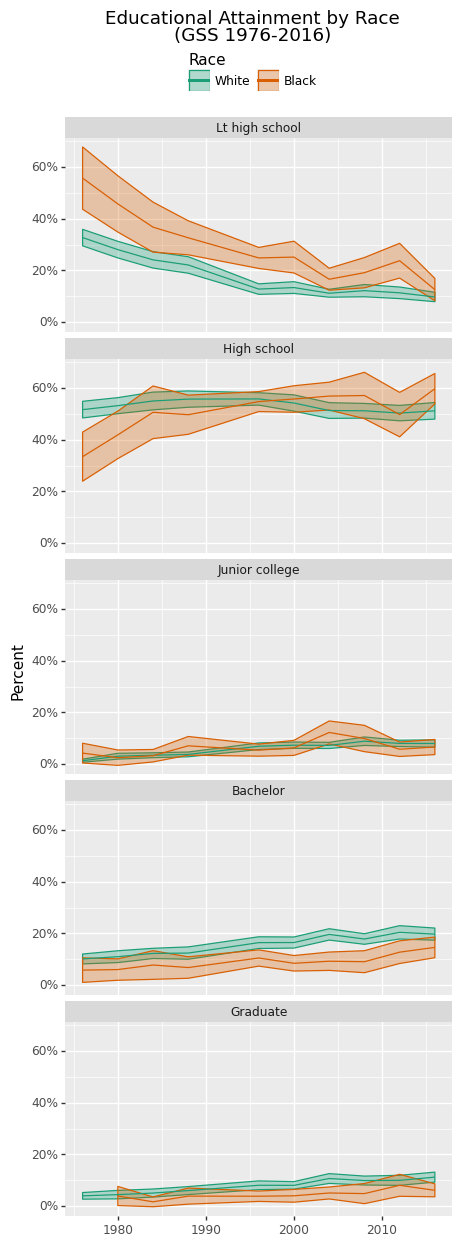

<ggplot: (329933517)>

In [192]:
# Figure 6.13

p = ggplot(data = out_grp,
           mapping = aes(x = 'year', 
                         y = 'prop', ymin = 'prop_low', ymax = 'prop_high',
                         fill = 'race_order',
                         color = 'race_order',
                         group = 'race_order'))

(p + geom_ribbon(alpha = 0.3) +
     geom_line() + 
     facet_wrap('degree_order', ncol = 1) +
     scale_y_continuous(labels = percent_format()) +
     scale_color_brewer(type = "qual", palette = "Dark2") +
     scale_fill_brewer(type = "qual", palette = "Dark2") +
     labs(title = "Educational Attainment by Race\n(GSS 1976-2016)\n\n\n\n",
          fill = "Race",
          color = "Race", 
          x = '', 
          y = "Percent") +
    theme(legend_position = "top",
          figure_size = (5, 14))
)

### 6.9 Where to go next

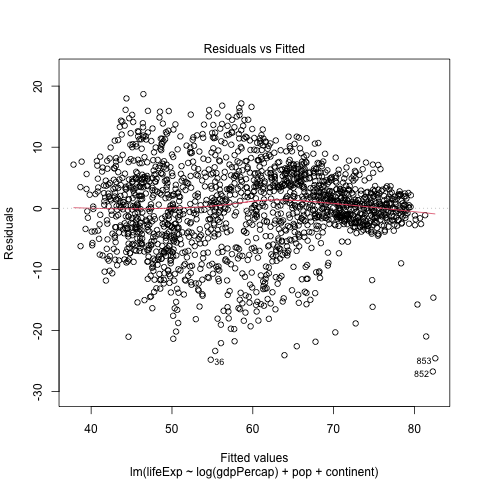

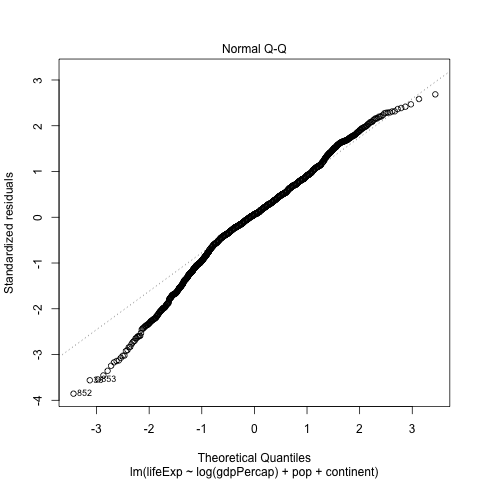

In [194]:
%%R -i gapminder

# This figure is not shown in the book, but the code is on p. 169

out <- lm(formula = lifeExp ~ log(gdpPercap) + pop + continent, data = gapminder)

# Plot not shown
plot(out, which = c(1,2), ask=FALSE)

In [193]:
# Figure 6.14 uses the coefplot package -- easy to mimic in matplotlib but not built in
# For now, we'll just use rpy2 again

coefplot = importr('coefplot')


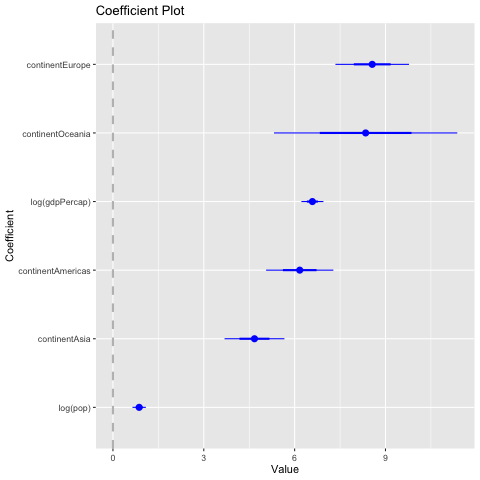

In [195]:
%%R -i gapminder

# Figure 6.14

library(coefplot)

out <- lm(formula = lifeExp ~ log(gdpPercap) + log(pop) + continent, data = gapminder)

coefplot(out, sort = "magnitude", intercept = FALSE)


In [ ]:
# Figure 6.15 uses a generalized pairs plot
# Recreate this in 3 different ways -- rpy2, seaborn, and matplotlib

In [208]:
# Option 1: just use rpy2 again

organdata2export = organdata.drop(columns = ['year',])

GGally = importr('GGally')


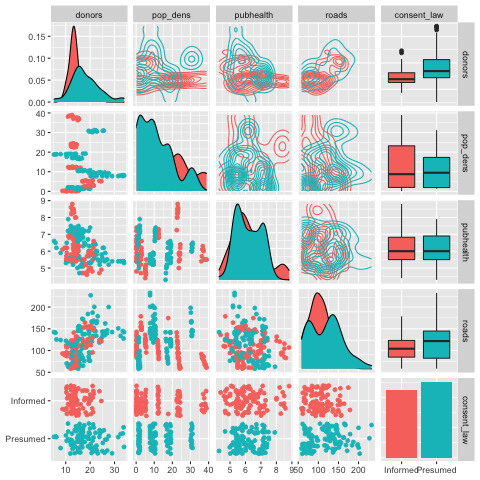

In [207]:
%%R -i organdata2export

# Figure 6.15

library(GGally)

organdata_sm <- organdata2export %>%
    select(donors, pop_dens, pubhealth,
           roads, consent_law)

ggpairs(data = organdata_sm,
        mapping = aes(color = consent_law),
        upper = list(continuous = wrap("density"), combo = "box_no_facet"),
        lower = list(continuous = wrap("points"),  combo = wrap("dot_no_facet")))


In [209]:
# Option 2: use seaborn
#   see: https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
# This is not exactly the same, but we can come pretty close with customization

import seaborn as sns

sns.set_context('talk', font_scale=1.2);

In [210]:
organdata_sm = organdata[['donors', 'pop_dens', 'pubhealth', 'roads', 'consent_law']]


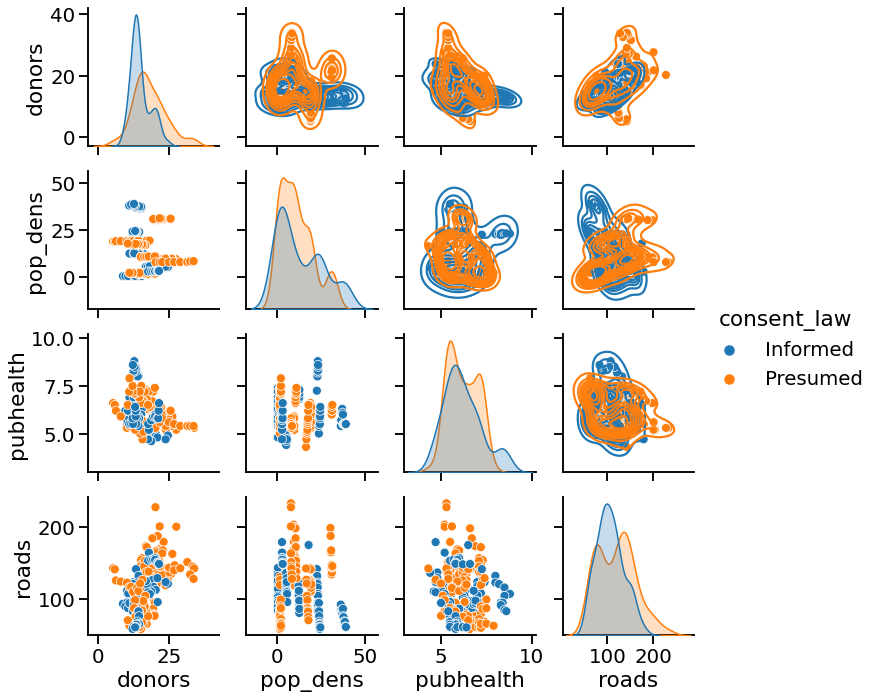

In [214]:
pp = sns.pairplot(organdata_sm, hue = 'consent_law')
pp.map_upper(sns.kdeplot)

array([[<AxesSubplot:xlabel='donors', ylabel='donors'>,
        <AxesSubplot:xlabel='pop_dens', ylabel='donors'>,
        <AxesSubplot:xlabel='pubhealth', ylabel='donors'>,
        <AxesSubplot:xlabel='roads', ylabel='donors'>],
       [<AxesSubplot:xlabel='donors', ylabel='pop_dens'>,
        <AxesSubplot:xlabel='pop_dens', ylabel='pop_dens'>,
        <AxesSubplot:xlabel='pubhealth', ylabel='pop_dens'>,
        <AxesSubplot:xlabel='roads', ylabel='pop_dens'>],
       [<AxesSubplot:xlabel='donors', ylabel='pubhealth'>,
        <AxesSubplot:xlabel='pop_dens', ylabel='pubhealth'>,
        <AxesSubplot:xlabel='pubhealth', ylabel='pubhealth'>,
        <AxesSubplot:xlabel='roads', ylabel='pubhealth'>],
       [<AxesSubplot:xlabel='donors', ylabel='roads'>,
        <AxesSubplot:xlabel='pop_dens', ylabel='roads'>,
        <AxesSubplot:xlabel='pubhealth', ylabel='roads'>,
        <AxesSubplot:xlabel='roads', ylabel='roads'>]], dtype=object)

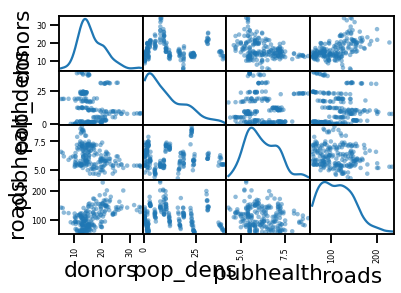

In [216]:
# Option 3: use pandas itself
#   see: https://www.marsja.se/pandas-scatter-matrix-pair-plot/
# This is quite clunky, but also much more straightforwardly customizable,
# as needed.

pd.plotting.scatter_matrix(organdata_sm, diagonal = 'kde')

### This completes the figures for chapter 6